![title](logo.png)

_____

# Desafio 8 - Descubra quem fez o ENEM 2016 apenas para treino
_____

### Base de Dados

O contexto do desafio gira em torno dos resultados do ENEM 2016 (disponíveis no arquivo enem_train.csv). Este arquivo, e apenas ele, deve ser utilizado para todos os desafios. 

Qualquer dúvida a respeito das colunas, consulte o [Dicionário dos Microdados do Enem 2016](https://s3-us-west-1.amazonaws.com/acceleration-assets-highway/data-science/dicionario-de-dados.zip).

Muitas universidades brasileiras utilizam o ENEM para selecionar seus futuros alunos e alunas. Isto é feito com uma média ponderada das notas das provas de matemática, ciências da natureza, linguagens e códigos, ciências humanas e redação. Determine os 20 melhores colocados, por ordem, para os pesos abaixo:

- matemática: 3
- ciências da natureza: 2
- linguagens e códigos: 1.5
- ciências humanas: 1
- redação: 3

O micro dados do INEP está disponível em: http://inep.gov.br/microdados


### Objetivo

Criar um modelo para descobrir quais estudantes estão fazendo a prova apenas para treino. 

Alguns estudantes decidem realizar prova do ENEM de forma precoce, como um teste (coluna **IN_TREINEIRO**). 

Neste desafio, você deve criar um modelo de classificação binária para inferir a mesma. 

Os resultados possíveis da sua resposta devem ser “0” ou “1”.

Salve sua resposta em um arquivo chamado answer.csv com duas colunas: **NU_INSCRICAO e IN_TREINEIRO**.

_______
### Importando as bibliotecas

In [507]:
import pandas as pd
import numpy as np
from IPython.display import Image
import joblib

# visualização gráfica
import seaborn as sns 
import matplotlib.pyplot as plt

# modelo
import sklearn
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import sklearn.metrics as metrics

import warnings
warnings.filterwarnings('ignore')

## Análise Exploratória
_______

Não fiz uma análise exploratória, pois o dataset é o mesmo do desafio da semana 7 de prever a nota de matemática. 

A parte exploratória você encontrará no arquivo _**prever_nota_enem.ipynb**_ que consta neste repositório.

## Pré-Processamento

____

### Ajustes

Como vimos, o tamanho das features dos dataset de treino e teste possuem tamanhos diferentes o que irá limitar um pouco nossa escolhas.

Para facilitar vou definir que ambos possuam a mesma quantidade de features.

In [482]:
# importa os arquivos test e train
test = pd.read_csv('./enem_test.csv', sep=",",encoding="utf-8")
train = pd.read_csv('./enem_train.csv',sep=",",encoding="utf-8")

# cria o dataset de respostas que será enviado ao desafio
df_resposta = pd.DataFrame()

# insere a coluna de inscrição
df_resposta['NU_INSCRICAO'] = test['NU_INSCRICAO'] 

In [483]:
# verifica os tamanhos dos dataset
print(train.shape)
print(test.shape)

(13730, 167)
(4570, 43)


In [484]:
# faz uma cópia do dataframe importado
df_train = train.copy()
df_test = test.copy()

In [485]:
# verifica as colunas que constam em teste.
columns_ajust = list(test.columns)
columns_ajust

['NU_INSCRICAO',
 'CO_UF_RESIDENCIA',
 'SG_UF_RESIDENCIA',
 'NU_IDADE',
 'TP_SEXO',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'TP_DEPENDENCIA_ADM_ESC',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_SABATISTA',
 'IN_GESTANTE',
 'IN_IDOSO',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_CH',
 'TP_PRESENCA_LC',
 'TP_PRESENCA_MT',
 'NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_LINGUA',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO',
 'Q001',
 'Q002',
 'Q006',
 'Q024',
 'Q025',
 'Q026',
 'Q027',
 'Q047']

In [486]:
# vamos adicionar a variável target nas features existentes 
columns_ajust.append('IN_TREINEIRO')
columns_ajust

['NU_INSCRICAO',
 'CO_UF_RESIDENCIA',
 'SG_UF_RESIDENCIA',
 'NU_IDADE',
 'TP_SEXO',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'TP_DEPENDENCIA_ADM_ESC',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_SABATISTA',
 'IN_GESTANTE',
 'IN_IDOSO',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_CH',
 'TP_PRESENCA_LC',
 'TP_PRESENCA_MT',
 'NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_LINGUA',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO',
 'Q001',
 'Q002',
 'Q006',
 'Q024',
 'Q025',
 'Q026',
 'Q027',
 'Q047',
 'IN_TREINEIRO']

In [487]:
# ajustar as colunas no dataset de treino ao de teste
df_train = df_train[columns_ajust]
df_train.head(2)

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,IN_TREINEIRO
0,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,RS,24,M,1,1,1,4,1,...,520.0,D,D,C,A,A,C,H,A,0
1,2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,CE,17,F,3,1,2,0,2,...,580.0,A,A,B,A,A,A,NaN,A,0


In [488]:
# a variável alvo já possui a saída binária
df_train['IN_TREINEIRO'].unique()

array([0, 1])

In [489]:
# valida os tamanhos dos dados
print(df_test.shape)
print(df_train.shape) # tem 01 a mais que é a nossa target 'IN_TREINEIRO'

(4570, 43)
(13730, 44)


### Verificar os Campos Nulos

Temos os mesmos campos nulos do desafio anterior de prever nota

- **Q027** representa um dado do questionário socioeconômico - "Com que idade você começou a exercer uma atividade remunerada?".
- **TP_ENSINO** - "Tipo de Instituição que concluiu ou concluirá o Ensino Médio"
- **TP_DEPENDENCIA_ADM_ESC** -"Dependência administrativa (Escola)"
- **NU_NOTA_$** - Correspondem aos campos das notas das provas: CN- Ciência da Natureza, CH- Ciência Humanas, LC- Linguagens e Códigos e MT- Matemática e Redação.

In [490]:
df_test.isnull().sum()

NU_INSCRICAO                 0
CO_UF_RESIDENCIA             0
SG_UF_RESIDENCIA             0
NU_IDADE                     0
TP_SEXO                      0
TP_COR_RACA                  0
TP_NACIONALIDADE             0
TP_ST_CONCLUSAO              0
TP_ANO_CONCLUIU              0
TP_ESCOLA                    0
TP_ENSINO                 3144
TP_DEPENDENCIA_ADM_ESC    3144
IN_BAIXA_VISAO               0
IN_CEGUEIRA                  0
IN_SURDEZ                    0
IN_DISLEXIA                  0
IN_DISCALCULIA               0
IN_SABATISTA                 0
IN_GESTANTE                  0
IN_IDOSO                     0
TP_PRESENCA_CN               0
TP_PRESENCA_CH               0
TP_PRESENCA_LC               0
TP_PRESENCA_MT               0
NU_NOTA_CN                1112
NU_NOTA_CH                1112
NU_NOTA_LC                1170
TP_LINGUA                    0
TP_STATUS_REDACAO         1170
NU_NOTA_COMP1             1170
NU_NOTA_COMP2             1170
NU_NOTA_COMP3             1170
NU_NOTA_

In [27]:
df_train.isnull().sum()

NU_INSCRICAO                 0
CO_UF_RESIDENCIA             0
SG_UF_RESIDENCIA             0
NU_IDADE                     0
TP_SEXO                      0
TP_COR_RACA                  0
TP_NACIONALIDADE             0
TP_ST_CONCLUSAO              0
TP_ANO_CONCLUIU              0
TP_ESCOLA                    0
TP_ENSINO                 9448
TP_DEPENDENCIA_ADM_ESC    9448
IN_BAIXA_VISAO               0
IN_CEGUEIRA                  0
IN_SURDEZ                    0
IN_DISLEXIA                  0
IN_DISCALCULIA               0
IN_SABATISTA                 0
IN_GESTANTE                  0
IN_IDOSO                     0
TP_PRESENCA_CN               0
TP_PRESENCA_CH               0
TP_PRESENCA_LC               0
TP_PRESENCA_MT               0
NU_NOTA_CN                3389
NU_NOTA_CH                3389
NU_NOTA_LC                3597
TP_LINGUA                    0
TP_STATUS_REDACAO         3597
NU_NOTA_COMP1             3597
NU_NOTA_COMP2             3597
NU_NOTA_COMP3             3597
NU_NOTA_

### Tratamento dos Campos Nulos

Algumas das possibilidades para tratar campos nulos são:

    - Exclui esses dados do dataset;
    - Preencher os campos com a média dos valores do campo e
    - Preencher os campos nulos com zeros.
    
 Como o dataset possui poucos registros excluir os campos faltantes pode ser prejudicial para o modelo.

 Preencher com a média dos valores no campo das notas não me parece correto. 
 Pois, estaria afirmando que o canditado fez a prova nos dois dias e que não houve falta. 

 Por fim, restou **preencher os campos nulos com zeros** e dessa forma o modelo não será treinado com valores faltantes. 
___

In [491]:
# substitui os campos nulos das features de TREINO por zero
df_train = df_train.fillna(0)
df_train.isnull().sum()

NU_INSCRICAO              0
CO_UF_RESIDENCIA          0
SG_UF_RESIDENCIA          0
NU_IDADE                  0
TP_SEXO                   0
TP_COR_RACA               0
TP_NACIONALIDADE          0
TP_ST_CONCLUSAO           0
TP_ANO_CONCLUIU           0
TP_ESCOLA                 0
TP_ENSINO                 0
TP_DEPENDENCIA_ADM_ESC    0
IN_BAIXA_VISAO            0
IN_CEGUEIRA               0
IN_SURDEZ                 0
IN_DISLEXIA               0
IN_DISCALCULIA            0
IN_SABATISTA              0
IN_GESTANTE               0
IN_IDOSO                  0
TP_PRESENCA_CN            0
TP_PRESENCA_CH            0
TP_PRESENCA_LC            0
TP_PRESENCA_MT            0
NU_NOTA_CN                0
NU_NOTA_CH                0
NU_NOTA_LC                0
TP_LINGUA                 0
TP_STATUS_REDACAO         0
NU_NOTA_COMP1             0
NU_NOTA_COMP2             0
NU_NOTA_COMP3             0
NU_NOTA_COMP4             0
NU_NOTA_COMP5             0
NU_NOTA_REDACAO           0
Q001                

In [492]:
# substitui os campos nulos das features de TESTE por zero
df_test= df_test.fillna(0)
df_test.isnull().sum()

NU_INSCRICAO              0
CO_UF_RESIDENCIA          0
SG_UF_RESIDENCIA          0
NU_IDADE                  0
TP_SEXO                   0
TP_COR_RACA               0
TP_NACIONALIDADE          0
TP_ST_CONCLUSAO           0
TP_ANO_CONCLUIU           0
TP_ESCOLA                 0
TP_ENSINO                 0
TP_DEPENDENCIA_ADM_ESC    0
IN_BAIXA_VISAO            0
IN_CEGUEIRA               0
IN_SURDEZ                 0
IN_DISLEXIA               0
IN_DISCALCULIA            0
IN_SABATISTA              0
IN_GESTANTE               0
IN_IDOSO                  0
TP_PRESENCA_CN            0
TP_PRESENCA_CH            0
TP_PRESENCA_LC            0
TP_PRESENCA_MT            0
NU_NOTA_CN                0
NU_NOTA_CH                0
NU_NOTA_LC                0
TP_LINGUA                 0
TP_STATUS_REDACAO         0
NU_NOTA_COMP1             0
NU_NOTA_COMP2             0
NU_NOTA_COMP3             0
NU_NOTA_COMP4             0
NU_NOTA_COMP5             0
NU_NOTA_REDACAO           0
Q001                

## Seleção das Features
_____

Apesar de algumas colunas possuírem valores númericos, não quer dizer que é um valor com ordem de grandeza.

São variáveis categóricas com a opções que ao invés de ser ums string são números.

As colunas: 
- CO_UF_RESIDENCIA
- TP_COR_RACA
- TP_NACIONALIDADE
- TP_ST_CONCLUSAO
- TP_ANO_CONCLUIU
- TP_ESCOLA
- TP_ENSINO
- TP_DEPENDENCIA_ADM_ESC 
- TP_PRESENCA_CN
- TP_PRESENCA_CH
- TP_PRESENCA_LC
- TP_STATUS_REDACAO

In [493]:
# separa os dados de treino e test
X_features = df_train.drop('IN_TREINEIRO', axis='columns')
y_features = df_train['IN_TREINEIRO']  # variável target

In [494]:
# separa apenas as variáveis categóricas
columns_transform = X_features.select_dtypes(exclude='number').columns.tolist()
columns_transform.extend(['CO_UF_RESIDENCIA',
                          'TP_COR_RACA',
                          'TP_NACIONALIDADE',
                          'TP_ST_CONCLUSAO',
                          'TP_ANO_CONCLUIU',
                          'TP_ESCOLA',
                          'TP_ENSINO',
                          'TP_DEPENDENCIA_ADM_ESC',
                          'TP_PRESENCA_CN',
                          'TP_PRESENCA_CH',
                          'TP_PRESENCA_LC',
                          'TP_STATUS_REDACAO'])
columns_transform

['NU_INSCRICAO',
 'SG_UF_RESIDENCIA',
 'TP_SEXO',
 'Q001',
 'Q002',
 'Q006',
 'Q024',
 'Q025',
 'Q026',
 'Q027',
 'Q047',
 'CO_UF_RESIDENCIA',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'TP_DEPENDENCIA_ADM_ESC',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_CH',
 'TP_PRESENCA_LC',
 'TP_STATUS_REDACAO']

In [495]:
# converte essas colunas em string para posterior transformação
X_features['Q027']= X_features['Q027'].astype(str)
X_features['Q027']= X_features['Q027'].astype(str)

In [496]:
# transforma as variáveis categórias em númericas
OHE = OneHotEncoder(sparse=False)
for coluna in X_features.columns:
    if coluna in columns_transform:
        try:
            X_features[coluna] = OHE.fit_transform(X_features[[coluna]])

        except:
            print(f"Nao foi possivel realizar a operacao para a coluna {coluna}")

In [497]:
# normaliza os dados
sc = StandardScaler()  
X_features = sc.fit_transform(X_features)

In [498]:
# analise dos componentes principais
pca = PCA(n_components=0.95).fit_transform(X_features)
pca.shape  # o segundo elemento da tupla é o número de componentes encontrados

(13730, 24)

In [508]:
# aplica o RFE com o número de componentes do PCA
estimador = GradientBoostingRegressor() 
rfe = RFE(estimador, 24, step=1)

In [509]:
rfe.fit(X_features,y_features)

RFE(estimator=GradientBoostingRegressor(), n_features_to_select=24)

In [511]:
# verifica as colunas
cols = rfe.get_support(indices=True)
features = df_train.iloc[:,cols]
features.head(2)

,NU_IDADE,TP_SEXO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,TP_PRESENCA_CH,TP_PRESENCA_LC,...,NU_NOTA_COMP1,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q024,Q025,Q026,Q047
0,24,M,1,4,1,0.0,0.0,0,1,1,...,120.0,120.0,80.0,80.0,520.0,D,A,A,C,A
1,17,F,2,0,2,1.0,2.0,0,1,1,...,140.0,120.0,120.0,80.0,580.0,A,A,A,A,A


In [512]:
# features escolhidas
features_columns = list(features.columns)
features_columns

['NU_IDADE',
 'TP_SEXO',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'TP_DEPENDENCIA_ADM_ESC',
 'IN_BAIXA_VISAO',
 'TP_PRESENCA_CH',
 'TP_PRESENCA_LC',
 'NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_LINGUA',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO',
 'Q001',
 'Q024',
 'Q025',
 'Q026',
 'Q047']

In [506]:
# verifica as variáveis já existem em features, sem considerar a variável alvo
print('Quantidade de Features:', len(features_columns))

Quantidade de Features: 24


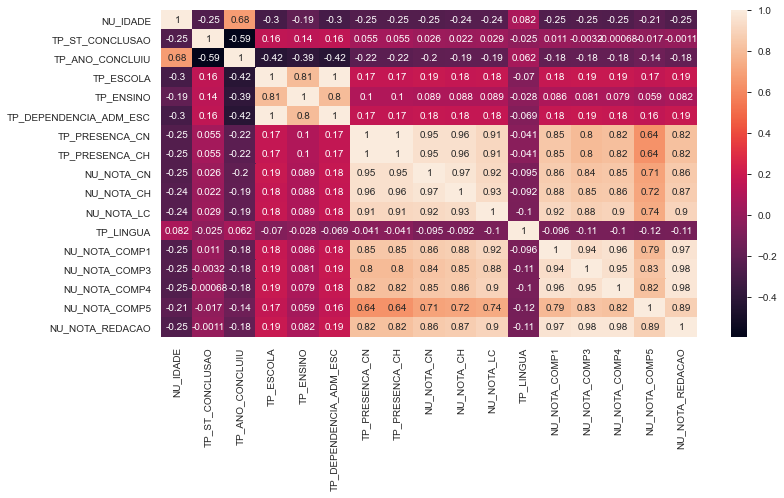

In [52]:
# mapa de calor para visualizar a correlação entre as variáveis escolhidas 
correlacoes_features = df_train[features_columns].corr()
plt.figure(figsize=(12, 6))
sns.heatmap(data=correlacoes_features, annot=True)

In [513]:
# armazena as features escolhidas com o RFE
features =['NU_IDADE',
           'TP_SEXO',
           'TP_ST_CONCLUSAO',
           'TP_ANO_CONCLUIU',
           'TP_ESCOLA',
           'TP_ENSINO',
           'TP_DEPENDENCIA_ADM_ESC',
           'NU_NOTA_CN',
           'NU_NOTA_CH',
           'NU_NOTA_LC',
           'TP_LINGUA',
           'NU_NOTA_COMP1',
           'NU_NOTA_COMP2',
           'NU_NOTA_COMP3',
           'NU_NOTA_COMP4',
           'NU_NOTA_COMP5',
           'NU_NOTA_REDACAO',
           'Q001',
           'Q006',
           'Q024',
           'Q025',
           'Q026',
           'Q027'] 

In [514]:
# verifica as vars categórias
categorical_var = df_train.select_dtypes(exclude='number').columns.tolist()
categorical_var

['NU_INSCRICAO',
 'SG_UF_RESIDENCIA',
 'TP_SEXO',
 'Q001',
 'Q002',
 'Q006',
 'Q024',
 'Q025',
 'Q026',
 'Q027',
 'Q047']

In [515]:
# converte essas colunas em string para posterior transformação
df_train['Q027']= df_train['Q027'].astype(str)
df_test['Q027']= df_test['Q027'].astype(str)

In [516]:
# ajusta o dataset com as features escolhidas
df_train = df_train[features]
df_train.head(2)

,NU_IDADE,TP_SEXO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,...,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q006,Q024,Q025,Q026,Q027
0,24,M,1,4,1,0.0,0.0,436.3,495.4,581.2,...,120.0,80.0,80.0,520.0,D,C,A,A,C,H
1,17,F,2,0,2,1.0,2.0,474.5,544.1,599.0,...,120.0,120.0,80.0,580.0,A,B,A,A,A,0


In [517]:
df_test = df_test[features]
df_test.head(2)

,NU_IDADE,TP_SEXO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,...,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q006,Q024,Q025,Q026,Q027
0,19,F,1,3,1,0.0,0.0,495.3,593.3,0.0,...,0.0,0.0,0.0,0.0,E,H,B,B,C,D
1,24,M,1,4,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,B,B,A,A,C,D


Codificação dos dados

In [518]:
# transforma as features TREINO não númericas em campos númericos
LE = LabelEncoder()
for coluna in df_train.columns:
        if coluna in categorical_var:
            try:
                df_train[coluna] = LE.fit_transform(df_train[[coluna]])

            except:
                print(f"Nao foi possivel realizar a operacao para a coluna {coluna}")

In [519]:
# transforma as features TESTE não númericas em campos númericos
LE = LabelEncoder()
for coluna in df_test.columns:
        if coluna in categorical_var:
            try:
                df_test[coluna] = LE.fit_transform(df_test[[coluna]])

            except:
                print(f"Nao foi possivel realizar a operacao para a coluna {coluna}")

Normalização dos dados

In [520]:
from sklearn.preprocessing import StandardScaler
X_minMax = MinMaxScaler()
for coluna in df_test.columns:
            try:
                df_test[coluna] = X_minMax.fit_transform(df_test[[coluna]])

            except:
                print(f"Nao foi possivel realizar a operacao para a coluna {coluna}")

In [521]:
from sklearn.preprocessing import StandardScaler
X_minMax = MinMaxScaler()
for coluna in df_train.columns:
            try:
                df_train[coluna] = X_minMax.fit_transform(df_train[[coluna]])

            except:
                print(f"Nao foi possivel realizar a operacao para a coluna {coluna}")

### Modelo com RandomForestClassifier

In [195]:
# separa os dados de treino e test
X_train = df_train
y_train = train['IN_TREINEIRO']  # variável target
X_test = df_test

In [196]:
# carrega o modelo
model_randomforest = RandomForestClassifier(random_state=42)
model_randomforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [197]:
# faz a classificação do treino
y_pred = model_randomforest.predict(X_test)

In [198]:
# armazena as classificações que o modelo preveu no dataset resposta
df_resposta['IN_TREINEIRO'] = np.around(y_pred,2)

In [199]:
# gera o arquivo de respostas com a classificação
df_resposta.to_csv('answer.csv', index=False, header=True)

In [200]:
# verifica o dataset final
df_resposta

,NU_INSCRICAO,IN_TREINEIRO
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,0
1,177f281c68fa032aedbd842a745da68490926cd2,0
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,1
3,5c356d810fa57671402502cd0933e5601a2ebf1e,0
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,0
...,...,...
4565,361b7fcd8867119550fe2af5aa729ffad89a7cf5,0
4566,d8a0e4c9e29494cc9bba2422bd79333931475ee1,0
4567,3f1c3388244df8d6521e983a809292d9f3bca643,0
4568,1778e9c4cef591beb6b986d191d15ed05de816b0,0


_____
- ### Score obtido no desafio: 98.687090%

features =['NU_IDADE',
           'TP_SEXO',
           'TP_ST_CONCLUSAO',
           'TP_ANO_CONCLUIU',
           'TP_ESCOLA',
           'TP_ENSINO',
           'TP_DEPENDENCIA_ADM_ESC',
           'TP_PRESENCA_CN',
           'TP_PRESENCA_CH',
           'NU_NOTA_CN',
           'NU_NOTA_CH',
           'NU_NOTA_LC',
           'TP_LINGUA',
           'NU_NOTA_COMP1',
           'NU_NOTA_COMP3',
           'NU_NOTA_COMP4',
           'NU_NOTA_COMP5',
           'NU_NOTA_REDACAO',
           'Q006',
           'Q024',
           'Q025',
           'Q026',
           'Q027',
           'Q047']

_______
## Reajuste das Features e Balanceamento dos Dados

In [125]:
# faz uma cópia do dataframe importado
df2_train = train.copy()
df2_test = test.copy()

In [126]:
# apenas as variáveis numéricas
num_vars = df2_test.select_dtypes(include='number').columns.tolist()
num_vars

['CO_UF_RESIDENCIA',
 'NU_IDADE',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'TP_DEPENDENCIA_ADM_ESC',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_SABATISTA',
 'IN_GESTANTE',
 'IN_IDOSO',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_CH',
 'TP_PRESENCA_LC',
 'TP_PRESENCA_MT',
 'NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_LINGUA',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO']

In [127]:
# seleciona apenas as variáveis numéricas para tratar os campos nulos com -1
df2_train[num_vars] = df2_train[num_vars].fillna(-1)
df2_test[num_vars] = df2_test[num_vars].fillna(-1)

In [129]:
# usa a variável NU_INSCRICAO como index
df2_train.set_index('NU_INSCRICAO', inplace=True)
df2_test.set_index('NU_INSCRICAO', inplace=True)

In [130]:
# valida os tamanhos dos dados
print(df2_train.shape)
print(df2_test.shape)

(13730, 166)
(4570, 42)


In [131]:
# verifica as colunas que constam em teste.
columns_ajust = list(df2_test.columns)
columns_ajust

['CO_UF_RESIDENCIA',
 'SG_UF_RESIDENCIA',
 'NU_IDADE',
 'TP_SEXO',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'TP_DEPENDENCIA_ADM_ESC',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_SABATISTA',
 'IN_GESTANTE',
 'IN_IDOSO',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_CH',
 'TP_PRESENCA_LC',
 'TP_PRESENCA_MT',
 'NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_LINGUA',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO',
 'Q001',
 'Q002',
 'Q006',
 'Q024',
 'Q025',
 'Q026',
 'Q027',
 'Q047']

In [132]:
# adicionar a variável target nas features existentes 
columns_ajust.append('IN_TREINEIRO')
columns_ajust

['CO_UF_RESIDENCIA',
 'SG_UF_RESIDENCIA',
 'NU_IDADE',
 'TP_SEXO',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'TP_DEPENDENCIA_ADM_ESC',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_SABATISTA',
 'IN_GESTANTE',
 'IN_IDOSO',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_CH',
 'TP_PRESENCA_LC',
 'TP_PRESENCA_MT',
 'NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_LINGUA',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO',
 'Q001',
 'Q002',
 'Q006',
 'Q024',
 'Q025',
 'Q026',
 'Q027',
 'Q047',
 'IN_TREINEIRO']

In [133]:
# ajustar as colunas no dataset de treino ao de teste
df2_train = df2_train[columns_ajust]
df2_train.head(2)

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,IN_TREINEIRO
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,
ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,RS,24,M,1,1,1,4,1,-1.0,...,520.0,D,D,C,A,A,C,H,A,0
2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,CE,17,F,3,1,2,0,2,1.0,...,580.0,A,A,B,A,A,A,NaN,A,0


In [134]:
# valida os tamanhos dos dados
print(df2_train.shape) # tem 01 a mais que é a nossa target 'IN_TREINEIRO'
print(df2_test.shape)

(13730, 43)
(4570, 42)


#### Seleciona apenas as features numéricas

In [135]:
# considerar apenas as colunas numéricas pra TREINO
df2_train = df2_train.select_dtypes(include='number')
df2_train.head(2)

,CO_UF_RESIDENCIA,NU_IDADE,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,...,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,IN_TREINEIRO
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,
ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,24,1,1,1,4,1,-1.0,-1.0,0,...,581.2,1,1.0,120.0,120.0,120.0,80.0,80.0,520.0,0
2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,17,3,1,2,0,2,1.0,2.0,0,...,599.0,1,1.0,140.0,120.0,120.0,120.0,80.0,580.0,0


In [80]:
# considerar apenas as colunas numéricas para TESTE
df2_test = df2_test.select_dtypes(include='number')
df2_test.head(2)

,CO_UF_RESIDENCIA,NU_IDADE,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,...,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,
ba0cc30ba34e7a46764c09dfc38ed83d15828897,43,19,1,1,1,3,1,-1.0,-1.0,0,...,593.3,-1.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
177f281c68fa032aedbd842a745da68490926cd2,15,24,3,2,1,4,1,-1.0,-1.0,0,...,-1.0,-1.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [136]:
correlations = df2_train.corr()

In [75]:
# mapa de calor das correlações
def criar_heatmap(corr):
  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr, dtype=np.bool))

  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(11, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

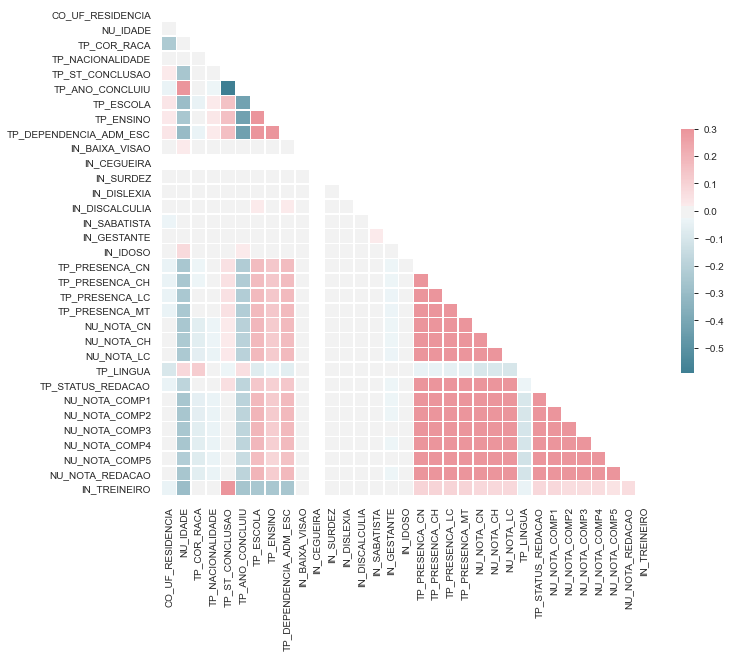

In [76]:
# visulizando
criar_heatmap(correlations)

In [139]:
# features númericas escolhidas
features = df2_train.columns.tolist()  # armazena em uma lista
features.remove('IN_TREINEIRO')  # remove a varável alvo
features

['CO_UF_RESIDENCIA',
 'NU_IDADE',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'TP_DEPENDENCIA_ADM_ESC',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_SABATISTA',
 'IN_GESTANTE',
 'IN_IDOSO',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_CH',
 'TP_PRESENCA_LC',
 'TP_PRESENCA_MT',
 'NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_LINGUA',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO']

In [468]:
# seleção de features que obteve o melhor score no desafio
features2= ['NU_IDADE',
            'CO_UF_RESIDENCIA',
            'TP_ST_CONCLUSAO',
            'TP_ENSINO',
            'TP_DEPENDENCIA_ADM_ESC',
            'IN_DISLEXIA',
            'IN_SABATISTA',
            'IN_GESTANTE',
            'IN_IDOSO',
            'TP_PRESENCA_CN',
            'TP_PRESENCA_CH',
            'TP_PRESENCA_LC',
            'TP_PRESENCA_MT',
            'NU_NOTA_CN',
            'NU_NOTA_LC',
            'NU_NOTA_CH',
            'TP_LINGUA',
            'TP_STATUS_REDACAO',
            'NU_NOTA_COMP1',
            'NU_NOTA_COMP2',
            'NU_NOTA_COMP3',
            'NU_NOTA_COMP4',
            'NU_NOTA_COMP5',
            'NU_NOTA_REDACAO']

## Modelo com os dados balanceados

In [469]:
# separa os dados de treino e test
X2_train = df2_train[features2]
y2_train = df2_train['IN_TREINEIRO']  # variável target
X2_test = df2_test[features2]

In [470]:
# balanceamento dos dados
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')

X2_train,y2_train = smote.fit_resample(X2_train,y2_train)

In [471]:
# carrega o modelo
model_randomforest = RandomForestClassifier(random_state=42)
model_randomforest.fit(X2_train, y2_train)

RandomForestClassifier(random_state=42)

In [472]:
# faz a classificação do treino
y2_pred = model_randomforest.predict(X2_test)

In [473]:
# cria o dataset de respostas que será enviado ao desafio
df2_resposta = pd.DataFrame()

# insere a coluna de inscrição
df2_resposta['NU_INSCRICAO'] = test['NU_INSCRICAO'] 

In [474]:
# armazena as classificações que o modelo preveu no dataset resposta
df2_resposta['IN_TREINEIRO'] = np.around(y2_pred,2)

In [475]:
# gera o arquivo de respostas com a classificação
df2_resposta.to_csv('answer.csv', index=False, header=True)

In [476]:
# verifica o dataset final
df2_resposta

,NU_INSCRICAO,IN_TREINEIRO
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,0
1,177f281c68fa032aedbd842a745da68490926cd2,0
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,1
3,5c356d810fa57671402502cd0933e5601a2ebf1e,0
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,0
...,...,...
4565,361b7fcd8867119550fe2af5aa729ffad89a7cf5,0
4566,d8a0e4c9e29494cc9bba2422bd79333931475ee1,0
4567,3f1c3388244df8d6521e983a809292d9f3bca643,0
4568,1778e9c4cef591beb6b986d191d15ed05de816b0,0


_______

 #### **Tratando os campos nulos com 0 (zero)**
- ##### Score obtido no desafio: **99.606127%**

**Features numéricas escolhidas:** 
['CO_UF_RESIDENCIA',
 'NU_IDADE',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'TP_DEPENDENCIA_ADM_ESC',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_SABATISTA',
 'IN_GESTANTE',
 'IN_IDOSO',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_CH',
 'TP_PRESENCA_LC',
 'TP_PRESENCA_MT',
 'NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_LINGUA',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO']

_______
 #### **Tratando os campos nulos com -1**
- ##### Score obtido no desafio: **98,730853%**

**Features numéricas escolhidas:** = ['NU_IDADE', 'TP_ST_CONCLUSAO']


- ##### Score obtido no desafio: **99.628090%**


**Features numéricas escolhidas:**
['CO_UF_RESIDENCIA',
 'NU_IDADE',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'TP_DEPENDENCIA_ADM_ESC',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_SABATISTA',
 'IN_GESTANTE',
 'IN_IDOSO',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_CH',
 'TP_PRESENCA_LC',
 'TP_PRESENCA_MT',
 'NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_LINGUA',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO']

______
- ### Score FINAL obtido no desafio da semana: **99,649891%**

**Features numéricas escolhidas:** = ['NU_IDADE',
            'CO_UF_RESIDENCIA',
             'TP_ST_CONCLUSAO',
             'TP_ENSINO',
            'TP_DEPENDENCIA_ADM_ESC',
             'IN_DISLEXIA',
             'IN_SABATISTA',
             'IN_GESTANTE',
             'IN_IDOSO',
            'TP_PRESENCA_CN',
             'TP_PRESENCA_CH',
             'TP_PRESENCA_LC',
             'TP_PRESENCA_MT',
             'NU_NOTA_CN',
             'NU_NOTA_LC',
            'NU_NOTA_CH',
             'TP_LINGUA',
             'TP_STATUS_REDACAO',
             'NU_NOTA_COMP1',
             'NU_NOTA_COMP2',
             'NU_NOTA_COMP3',
             'NU_NOTA_COMP4',
             'NU_NOTA_COMP5',
             'NU_NOTA_REDACAO']
             


![title](score_enem4.png)

____
## Conclusão
___

Aplicando o balanceamento de dados obtive um resultado melhor para o modelo. 

Pra esse desafio da semana também utilizei o modelo RandomForestClassifier obtive um bom score final de 99,649891%.

Nesse modelo usei com features apenas as variáveis númericas, como próximos passos é testar usando também as categóricas.

Esse foi o último desafio do programa de aceleração de Data Science da Codenation. 